### Notebook Overview: Predictive Modeling for WAITTIME
This notebook integrates the complete predictive modeling workflow for WAITTIME, combining various stages that were previously distributed across multiple scripts into a cohesive and streamlined process. It focuses on predicting WAITTIME as a continuous variable using regression techniques, which allow for a more nuanced understanding of factors influencing wait durations:

- **Unified Modeling Pipeline**: It combines key components from separate files into one notebook for a streamlined process.
- **Model Selection and Validation**: Cross-validation techniques are employed to select the best regression model.
- **Hyperparameter Optimization**: The chosen model's hyperparameters are tuned using the validation set to maximize accuracy.
- **Model Evaluation**: The optimized model is tested against a separate dataset to ensure accuracy and generalizability.

- **Importing Libraries**: Essential libraries for regression are imported to support modeling tasks.
- **Project Configuration**: Root setup and configurations are centralized through `config.py`, promoting consistent execution.
- **Data Preprocessing**: `DataPreprocessingPipeline` from the `utils.py` module located at /scripts/preprocessing/ ensures data is cleaned, engineered, split, and processed efficiently.
- **Class Organization**: Custom classes for preprocessing are maintained in the `scripts` directory, allowing for modular use.

- **File Organization**: Data files are neatly organized into subfolders within the `data` directory for better management.
- **Consistent Configuration**: `config.py` provides unified path management and global variables like `random_state` and `seed` for reproducibility.


In [1]:
# Install essential libraries for regression
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import shap
import scipy.sparse
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Set the project root path
project_root = Path.cwd().parents[0]

# Insert the project root path to the system path
sys.path.insert(0, str(project_root))

# Import configuration settings
import config
from config import RANDOM_SEED

# Set the random seed
config.set_seed()

# Import our custom utility functions
from utils import DataPreprocessingPipeline

In [2]:

# Load the raw data from the data/raw directory using the load_data method from the config module located at config.org
emergency_df = config.load_data('nhamcs14.sas7bdat', 'raw')

####  **Data Preprocessing Pipeline**:

- **Data Preprocessing Pipeline**: The below section of the code uses a comprehensive pipeline located at /scripts/preprocessing/ for preprocessing data specifically for regression tasks with a focus on predicting the `WAITTIME` variable. The key steps in this pipeline include:
  - **Data Preparation**: Applying a series of preprocessing techniques to clean and prepare the data for modeling.
  - **Dataset Splitting**: Segregating the preprocessed data into distinct training, validation, and testing sets to support various phases of model training and evaluation.
  - **Feature Recording**: Persistently storing the names of the features in a CSV file after preprocessing, which serves as a handy reference for later stages of the modeling process.


In [3]:
# Main target variable
target = 'WAITTIME'
#Remove additional target variables that are not required for this task
target_to_drop = ['WAITTIME_BINARY', 'LOV_BINARY']

# Create a data preprocessing pipeline
pipeline = DataPreprocessingPipeline(emergency_df=emergency_df, target=target, target_to_drop=target_to_drop, percent_train=0.70, percent_val=0.15, percent_test=0.15, stratify=False)
pipeline.run()

# Extract preprocessed data splits and other relevant information
X_train = pipeline.X_train
X_validation = pipeline.X_validation
X_test = pipeline.X_test
y_train = pipeline.y_train
y_validation = pipeline.y_validation
y_test = pipeline.y_test
X_train_preprocessed = pipeline.X_train_preprocessed
X_validation_preprocessed = pipeline.X_validation_preprocessed
X_test_preprocessed = pipeline.X_test_preprocessed
feature_names = pipeline.feature_names
cleaned_emergency_df = pipeline.cleaned_emergency_df
transformed_emergency_df = pipeline.transformed_emergency_df

# Clean up feature names for better readability
feature_names = [name.replace('num__', '').replace('cat__', '') for name in feature_names]
feature_names_list = list(feature_names)

# Save feature names to a CSV file
config.save_data(feature_names, f"features_{target}.csv", 'features')

1-Cleaning data...
Data cleaning completed
Size of Initial dataset:(23844, 1012)
Size of cleaned dataset:(17620, 370)

2-Applying feature engineering...
Feature engineering completed
Size of the dataset after feature engineering:(17620, 387)

3-Splitting data...
self.stratify: False
Splitting data completed

4-Loading data...
train_df size: (12333, 387)
X_train size: (12333, 386)
y_train size: (12333,)

validation_df size: (2643, 387)
X_validation size: (2643, 386)
y_validation size: (2643,)

test_df size: (2644, 387)
X_test size: (2644, 386)
y_test size: (2644,)
Loading data completed

5-Preprocessing data...
Preprocessing data completed.
Processor saved successfully


#### Model Selection and Preservation
- **Regression Model Selection**: This next code section is responsible for the initialization and evaluation of a suite of regression models. Specifically, it:
  - **Model Dictionary Definition**: Establishes a dictionary that maps model names to their respective instances, each initialized with default parameters suitable for regression analysis.
  - **Performance Evaluation**: Employs cross-validation to assess the performance of each model based on the Mean Absolute Error (MAE) and R-squared (R2) metrics.
  - **Model Loop**: Iterates over each model, performing cross-validation and calculating the average MAE and R2 for each fold.
  - **Best Model Update**: Dynamically updates the record of the best model if a candidate model demonstrates superior performance in terms of lower MAE and higher R2.

- **Results and Preservation**: Upon completion of the evaluation:
  - **Best Model Display**: Outputs the details of the model that achieved the best cross-validation scores.
  - **Model Saving**: Serializes the best-performing model instance to a file for future reference and deployment.


In [4]:

# Define dictionary of models with their default parameters
models_with_defaults = {
    "CatBoostRegressor": {
        "model": CatBoostRegressor(random_state=RANDOM_SEED, verbose=0)
    },
    "LGBMRegressor": {
        "model": LGBMRegressor(
            random_state=RANDOM_SEED, force_col_wise=True, verbosity=-1
        )
    },
    "Ridge": {"model": Ridge()},
    "Lasso": {"model": Lasso()},
    "GradientBoostingRegressor": {
        "model": GradientBoostingRegressor(random_state=RANDOM_SEED)
    },
    "XGBRegressor": {"model": XGBRegressor(random_state=RANDOM_SEED)},
}

best_model = None
best_mae = float("inf")  # Initialize with infinity
best_r2 = -float("inf")  # Initialize with negative infinity
scoring = ["neg_mean_absolute_error", "r2"]
R2_TOLERANCE = 0.05
MAE_TOLERANCE = 0.01


# Prepare X_train_selected_features based on the format of X_train_preprocessed
if scipy.sparse.issparse(X_train_preprocessed):
    X_train_selected_features = X_train_preprocessed.toarray()
else:
    X_train_selected_features = X_train_preprocessed

results = []

# Loop over each model and evaluate their performance using cross-validation
for model_name, model_info in models_with_defaults.items():
    model = model_info["model"]

    # Perform cross-validation
    cv_results = cross_validate(
        model, X_train_selected_features, y_train, cv=5, scoring=scoring
    )

    # Calculate the average of the cross-validation scores
    mean_mae_validation = -1 * cv_results["test_neg_mean_absolute_error"].mean()
    mean_r2_validation = cv_results["test_r2"].mean()


    results.append({
        "Model Name": model_name,
        "MAE": mean_mae_validation,
        "R2": mean_r2_validation
    })

    # Update best model if current model performs better based on MAE and R2
    if (
        (mean_mae_validation < best_mae and mean_r2_validation > best_r2)
        or (
            mean_mae_validation < best_mae
            and mean_r2_validation >= best_r2 * (1 - R2_TOLERANCE)
        )
        or (
            mean_mae_validation <= best_mae * (1 + MAE_TOLERANCE)
            and mean_r2_validation > best_r2
        )
        or (mean_r2_validation == best_r2 and mean_mae_validation < best_mae)
    ):
        best_model = model
        best_mae = mean_mae_validation
        best_r2 = mean_r2_validation

# Create a DataFrame from the results
results_df = pd.DataFrame(results)
results_df['Is Best Model'] = (results_df['Model Name'] == best_model.__class__.__name__).map({True: 'Yes', False: 'No'})


# Select only numerical columns and round them to two decimal places
numerical_cols = results_df.select_dtypes(include=np.number).columns
results_df[numerical_cols] = results_df[numerical_cols].round(2)


# Display the best model based on cross-validation
print("Best Model Based on Cross-Validation:")
print(f"Model Name: {best_model.__class__.__name__}")
print(f"Best Cross-Validation MAE: {best_mae:.2f}")
print(f"Best Cross-Validation R-squared: {best_r2:.2f}")


# Save the best model instance, not its name
model_filename = "best_waittime_regression_model.joblib"
# Adjusted to directly save the model instance
config.save_model(best_model, model_filename) 
print(f"{model_filename} saved")
results_df

Best Model Based on Cross-Validation:
Model Name: LGBMRegressor
Best Cross-Validation MAE: 15.13
Best Cross-Validation R-squared: 0.29
best_waittime_regression_model.joblib saved


,Model Name,MAE,R2,Is Best Model
0,CatBoostRegressor,15.19,0.29,No
1,LGBMRegressor,15.13,0.29,Yes
2,Ridge,17.10,0.13,No
3,Lasso,18.49,0.03,No
4,GradientBoostingRegressor,16.13,0.23,No
5,XGBRegressor,15.88,0.23,No


#### Feature Importance Visualization**:
  - **SHAP Summary Plot**: The following code cell generates a SHAP (SHapley Additive exPlanations) summary plot, which visually represents the impact of each feature on the model's predictions.
  - **Top Feature Extraction**: This step is designed to identify the n most influential features for the regression model based on the SHAP values.
  - **Saving Selected Features**: After pinpointing the key features, the code saves this subset for future use in regression modeling, ensuring that the model training is focused on the most relevant predictors.



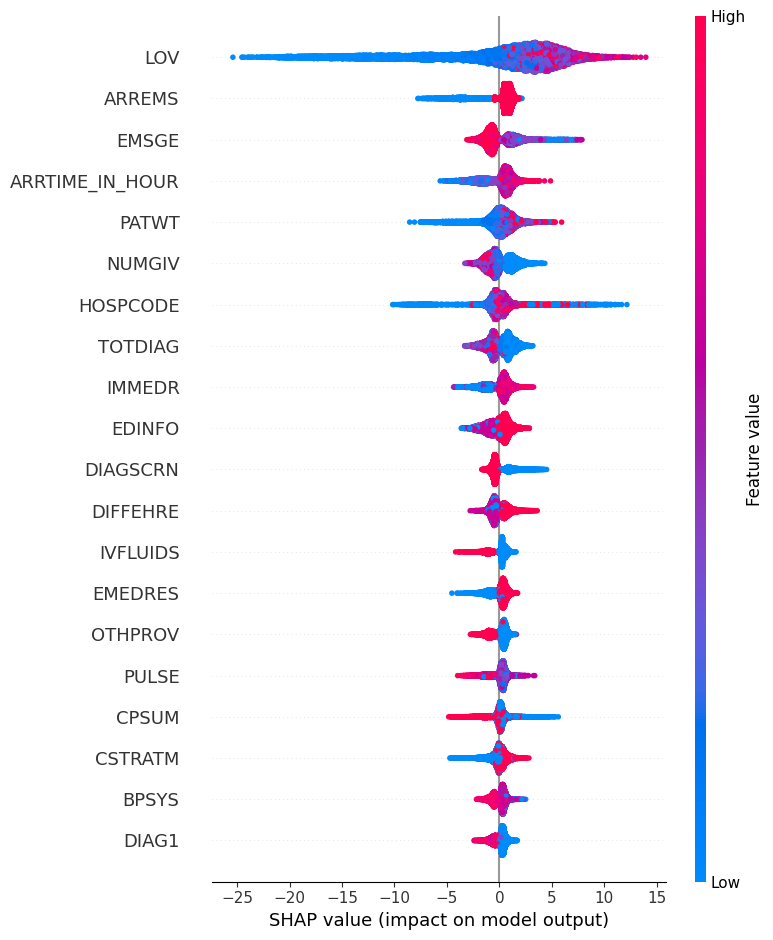

In [5]:
# Initialize the best model
model = best_model
model.fit(X_train_preprocessed, y_train)

def plot_and_return_top_n_shap(model, X_train_preprocessed, feature_names, n=20):
    """
    Plots SHAP summary plot of the top N features and returns their names without prefixes.
    """
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train_preprocessed)
    
    shap.summary_plot(shap_values, X_train_preprocessed, feature_names=feature_names, max_display=n, show=False)
    
    shap_sum = np.abs(shap_values).mean(axis=0)
    importance_df = pd.DataFrame(list(zip(feature_names, shap_sum)), columns=['feature_name', 'shap_importance'])
    importance_df.sort_values(by='shap_importance', ascending=False, inplace=True)
    
    importance_df['feature_name'] = importance_df['feature_name'].str.replace(r'^(num__|cat__)', '', regex=True)
    
    return importance_df.head(n)['feature_name'].tolist()

top_features = plot_and_return_top_n_shap(model=model, X_train_preprocessed=X_train_preprocessed, feature_names=feature_names_list, n=20)

top_feature_indices = [feature_names_list.index(feature) for feature in top_features]
X_train_selected_features = X_train_preprocessed[:, top_feature_indices]
X_validation_selected_features = X_validation_preprocessed[:, top_feature_indices] if X_validation_preprocessed.size > 0 else X_validation_preprocessed
X_test_selected_features = X_test_preprocessed[:, top_feature_indices]

config.save_data(top_features, f"top_features_{target}.csv", 'features')
config.save_data(top_feature_indices, f"feature_indices_{target}.csv", 'features')
config.save_data(X_train_selected_features, f"X_train_selected_features_{target}.csv", subdir='train', column_names=top_features)
config.save_data(X_validation_selected_features, f"X_validation_selected_features_{target}.csv", subdir='validation', column_names=top_features)
config.save_data(X_test_selected_features, f"X_test_selected_features_{target}.csv", subdir='test', column_names=top_features)

#### Hyperparameter Tuning

- **Optimization Process**:
  - **GridSearchCV Application**: The code employs `GridSearchCV` to methodically explore different hyperparameter combinations for the model, aiming to optimize predictions for wait time.
  - **Best Hyperparameters Utilization**: Once the optimal hyperparameters are identified, they are applied to train the final model across the entire training dataset.
  - **Validation Set Performance**: The model's effectiveness is assessed using the validation set to ensure its reliability and robustness.
  - **Model Saving**: The fine-tuned model, now ready for deployment, is saved to facilitate future use and further evaluation.


In [6]:

# Define a range of hyperparameters for CatBoostRegressor
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [30, 50, 100],
    'l2_leaf_reg': [1, 3, 5]
}
# Initialize the best model and GridSearchCV
model = best_model
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)
# Perform hyperparameter tuning
print("Starting hyperparameter tuning...")
grid_search.fit(X_train_preprocessed, y_train)
# Retrieve and report the best hyperparameters
best_hyperparams = grid_search.best_params_
# Training the final model with best hyperparameters on the entire training data
best_model = grid_search.best_estimator_
# Evaluate on validation set
y_validation_pred = best_model.predict(X_validation_preprocessed)
mae_validation = mean_absolute_error(y_validation, y_validation_pred)
r2_validation = r2_score(y_validation, y_validation_pred)
print(f"Validation MAE: {mae_validation:.2f}, R2: {r2_validation:.2f}")
# Save the best trained model
model_filename = f"best_waittime_regression_model_with_all_features.joblib"
config.save_model(best_model, model_filename)
# Print confirmation
print(f"{best_model} saved")

Starting hyperparameter tuning...
Fitting 5 folds for each of 81 candidates, totalling 405 fits


#### Model Retraining and Evaluation
  - **Focused Feature Set**: Utilizes only the top 60 features identified as most impactful, applying the best hyperparameters for retraining the model.
  - **Validation Prediction**: Makes predictions on the validation set to evaluate the refined model's performance.
  - **Model Saving**: Archives the trained model for future use.
  - **Confirmation**: Outputs a confirmation message upon successful completion of these steps.


In [ ]:

best_model.fit(X_train_selected_features, y_train)
y_validation_pred = best_model.predict(X_validation_selected_features)
mae_validation = mean_absolute_error(y_validation, y_validation_pred)
r2_validation = r2_score(y_validation, y_validation_pred)

print(f"Validation MAE: {mae_validation:.2f}, R2: {r2_validation:.2f}")

model_name = 'best_waittime_regression_model_with_top_features.joblib'
config.save_model(best_model, model_name)

print(f"{model_name} saved")


Validation MAE: 15.55, R2: 0.29
best_waittime_regression_model_with_top_features.joblib saved


#### Evaluation of Best Model on Test Data
  - **Model Loading**: Retrieves a previously trained regression model from storage.
  - **Test Data Evaluation**: Applies the model to the test data to assess its predictive accuracy.
  - **MAE and R-Squared**: Computes the Mean Absolute Error (MAE) and R-squared (R2) metrics to quantitatively measure the model's performance.
  - **Results Output**: Displays the calculated metrics, providing insights into the model’s effectiveness in real-world scenarios.



In [ ]:

# Define the paths for the model and test data
model_name = 'best_waittime_regression_model_with_all_features.joblib'
# Load the trained model using the utility function from config.py
model = config.load_model(model_name)
print("Model loaded successfully.")
# Evaluate the model on the test data for all features
y_pred = model.predict(X_test_preprocessed)
# Calculate the evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
# Print the evaluation metrics
print(f"Mean Absolute Error (MAE) on Test Data: {round(mae, 2)}")
print(f"R-squared on Test Data: {round(r2, 2)}")

Model loaded successfully.
Mean Absolute Error (MAE) on Test Data: 15.42
R-squared on Test Data: 0.29


#### Model Testing and Performance Evaluation
  - **Source File**: Retrieves the regression model from a `joblib` file named `best_waittime_regression_model_with_top_features.joblib`.
  - **Test Data Predictions**: Utilizes the loaded model to make predictions on the test dataset.
  - **Evaluation Metrics**: Calculates key performance indicators, including Mean Absolute Error (MAE) and R-squared (R2), to measure the model's accuracy and fit.


In [ ]:
# Define the paths for the model and test data
model_name = 'best_waittime_regression_model_with_top_features.joblib'
# Load the trained model using the utility function from config.py
model = config.load_model(model_name)
print("Model loaded successfully.")
# Now, make the prediction
y_pred = model.predict(X_test_selected_features)
# Calculate and print the evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error (MAE) on Test Data: {round(mae, 2)}")
print(f"R-squared on Test Data: {round(r2, 2)}")

Model loaded successfully.
Mean Absolute Error (MAE) on Test Data: 15.49
R-squared on Test Data: 0.28


#### Visualization of Model Predictions
  - **Scatter Plot**: Displays the predicted values versus the actual values from the regression model, enhancing visual assessment of model performance.
  - **Perfect Prediction Line**: Includes a diagonal line that represents the ideal scenario where predicted values perfectly match the true values.
  - **Performance Insight**: This visualization is crucial for intuitively understanding the model's accuracy in predicting the target variable.



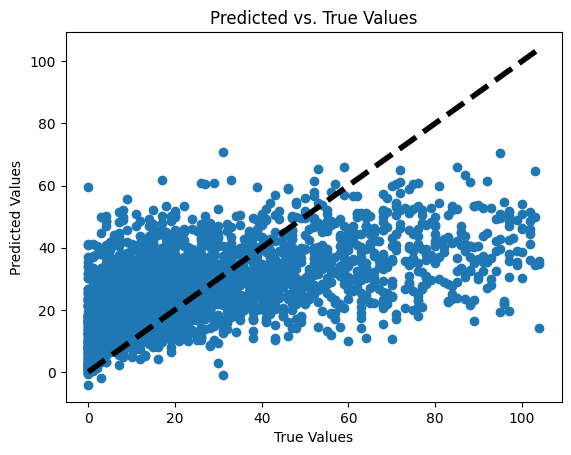

In [ ]:

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. True Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()